# Imports and Setup

In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

dataset_dir = "./melanoma_cancer_dataset"

BATCH_SIZE = 16  
IMAGE_SIZE = (128, 128)  
EPOCHS = 10


# Visualizing some images from the Dataset

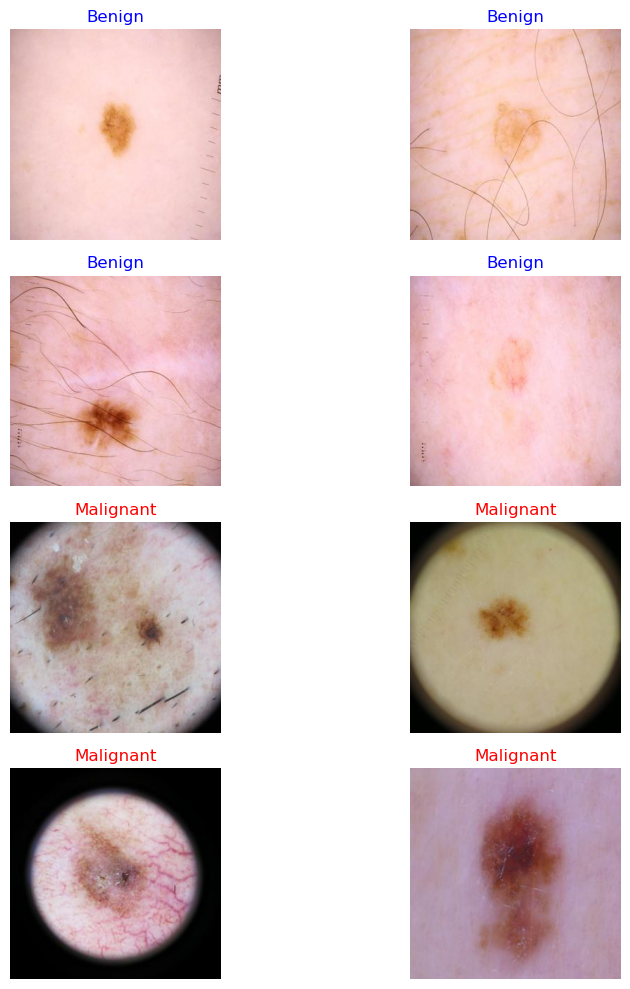

In [2]:
data = {"train": {"benign": [], "malignant": []}, "test": {"benign": [], "malignant": []}}

for folder in ["train", "test"]:
    for category in ["benign", "malignant"]:
        category_path = os.path.join(dataset_dir, folder, category)
        file_paths = glob(os.path.join(category_path, "*.jpg"))
        data[folder][category].extend(file_paths)

plt.figure(figsize=(10, 10))

for i, filepath in enumerate(data["train"]["benign"][:4]):
    image = Image.open(filepath)
    plt.subplot(4, 2, i + 1)
    plt.imshow(image)
    plt.title("Benign", color="blue", fontsize=12)
    plt.axis("off")

for i, filepath in enumerate(data["train"]["malignant"][:4]):
    image = Image.open(filepath)
    plt.subplot(4, 2, i + 5)
    plt.imshow(image)
    plt.title("Malignant", color="red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Counting the number of files by category

In [3]:
image_counts = {"train": {"benign": 0, "malignant": 0}, "test": {"benign": 0, "malignant": 0}}

for folder in ["train", "test"]:
    for category in ["benign", "malignant"]:
        category_path = os.path.join(dataset_dir, folder, category)
        if os.path.exists(category_path):
            num_images = len(glob(os.path.join(category_path, "*.jpg")))
            image_counts[folder][category] = num_images
            print(f"{folder}/{category}: {num_images} images")

train/benign: 5000 images
train/malignant: 4605 images
test/benign: 500 images
test/malignant: 500 images


# Load and preprocess the data

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def create_balanced_dataset(data, folder, image_size, batch_size):
    benign_files = data[folder]["benign"]
    malignant_files = data[folder]["malignant"]

    all_files = benign_files + malignant_files
    labels = [0] * len(benign_files) + [1] * len(malignant_files)

    combined = list(zip(all_files, labels))
    np.random.shuffle(combined)
    all_files, labels = zip(*combined)

    file_ds = tf.data.Dataset.from_tensor_slices((list(all_files), list(labels)))
    image_ds = file_ds.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x)), image_size) / 255, y))
    
    return image_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = create_balanced_dataset(data, "train", IMAGE_SIZE, BATCH_SIZE)
val_ds = create_balanced_dataset(data, "test", IMAGE_SIZE, BATCH_SIZE) 

# Build a Convolutional Neural Network Model

In [9]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 126, 126, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 61, 61, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,691,937 (14.08 MB)

 Trainable params: 3,691,841 (14.08 MB)

 Non-trainable params: 96 (384.00 B)

# Training

In [11]:
training = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[TensorBoard(log_dir="logs")]
)


Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 130s 216ms/step - accuracy: 0.9691 - loss: 0.0809 - val_accuracy: 0.8930 - val_loss: 0.3426
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 128s 213ms/step - accuracy: 0.9674 - loss: 0.0892 - val_accuracy: 0.8830 - val_loss: 0.4353
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 114s 190ms/step - accuracy: 0.9717 - loss: 0.0805 - val_accuracy: 0.9110 - val_loss: 0.3638
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 106s 177ms/step - accuracy: 0.9732 - loss: 0.0748 - val_accuracy: 0.9010 - val_loss: 0.3641
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 113s 187ms/step - accuracy: 0.9832 - loss: 0.0464 - val_accuracy: 0.9060 - val_loss: 0.4189
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 113s 188ms/step - accuracy: 0.9805 - loss: 0.0527 - val_accuracy: 0.8890 - val_loss: 0.4243
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 122s 203ms/step - accuracy: 0.9845 - loss: 0.0441 - val_accuracy: 0.8990 - val_loss: 0.4396
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 126s 209ms/step - accuracy: 0.9820 -

# Plot Performance

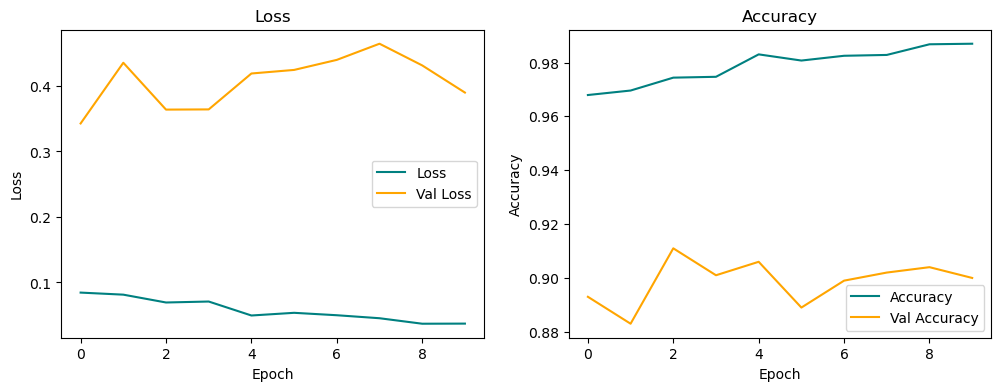

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], label='Loss', color='teal')
plt.plot(training.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], label='Accuracy', color='teal')
plt.plot(training.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Test and Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

<Figure size 1000x1000 with 0 Axes>

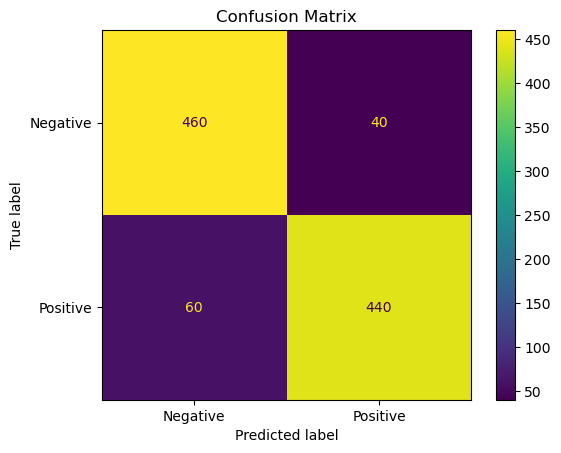

<Figure size 1000x1000 with 0 Axes>

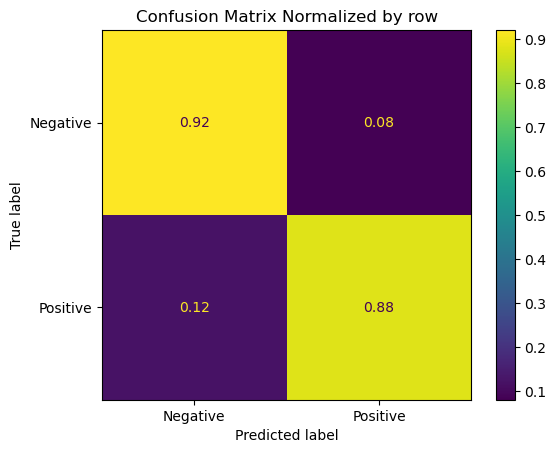

<Figure size 1000x1000 with 0 Axes>

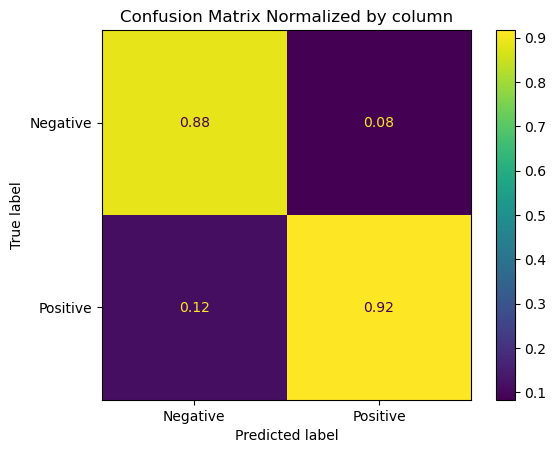

<Figure size 1000x500 with 0 Axes>

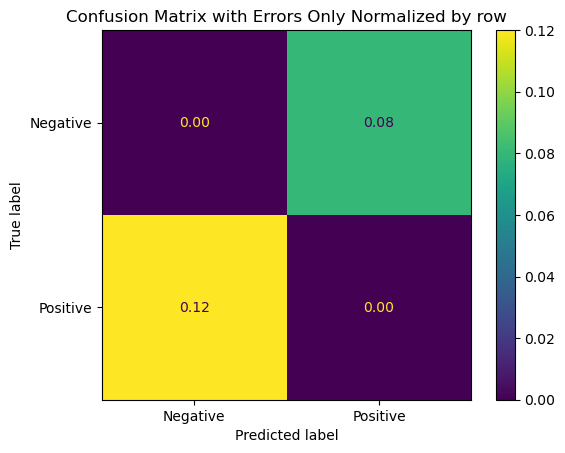

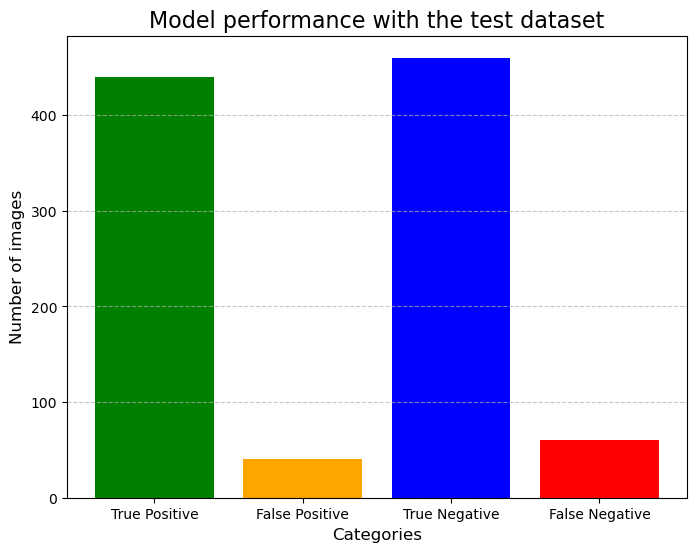

Number of positive images : 480
Total number of images : 1000


In [17]:
y_true = []
y_pred = []

for batch in val_ds:
    X, y = batch 
    yhat = model.predict(X).flatten()  
    y_true.extend(y.numpy())  
    y_pred.extend(yhat > 0.5) 

y_true = np.array(y_true)
y_pred = np.array(y_pred).astype(int)

cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix:\n{cm}")
print(f"True Positive (TP): {tp}")
print(f"False Positive (FP): {fp}")
print(f"True Negative (TN): {tn}")
print(f"False Negative (FN): {fn}")

print(f"Classification Report:\n{classification_report(y_true, y_pred)}")

plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="viridis", values_format="d")
plt.title("Confusion Matrix")
plt.show()

cm_normalized_row = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 10))
disp_row = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_row, display_labels=["Negative", "Positive"])
disp_row.plot(cmap="viridis", values_format=".2f")
plt.title("Confusion Matrix Normalized by row")
plt.show()

cm_normalized_col = cm.astype('float') / cm.sum(axis=0, keepdims=True)
plt.figure(figsize=(10, 10))
disp_col = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_col, display_labels=["Negative", "Positive"])
disp_col.plot(cmap="viridis", values_format=".2f")
plt.title("Confusion Matrix Normalized by column")
plt.show()

cm_errors_row = cm_normalized_row.copy()
np.fill_diagonal(cm_errors_row, 0)

plt.figure(figsize=(10, 5))
disp_err_row = ConfusionMatrixDisplay(confusion_matrix=cm_errors_row, display_labels=["Negative", "Positive"])
disp_err_row.plot(cmap="viridis", values_format=".2f")
plt.title("Confusion Matrix with Errors Only Normalized by row")
plt.show()

categories = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
values = [tp, fp, tn, fn]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'orange', 'blue', 'red'])
plt.title('Model performance with the test dataset', fontsize=16)
plt.ylabel('Number of images', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Number of positive images : {np.sum(y_pred)}")
print(f"Total number of images : {len(y_pred)}")

